# Feature engineering and model stacking for car price modelling

Let's use the Feature-engine python library to create 3 different pipelines of variable transformation. Then train several machine learning models utilizing the transformed datasets, tuning their parameters with cross-validation, and combine the models through stacking.

In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns=200
import klib
import seaborn as sns
from scipy.stats import uniform, randint
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import(
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate
)
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.linear_model import ElasticNet 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from feature_engine import creation
from feature_engine import discretisation as disc 
from feature_engine import encoding as enc 
from feature_engine import imputation as imp 
from feature_engine import selection as sel 
from feature_engine import transformation as tf 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# load data
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)
cars = cars.replace('?', np.nan)
cars.head()

symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3               NaN  alfa-romero       gas        std          two   
1          3               NaN  alfa-romero       gas        std          two   
2          1               NaN  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  length  width  \
0  convertible          rwd           front        88.6   168.8   64.1   
1  convertible          rwd           front        88.6   168.8   64.1   
2    hatchback          rwd           front        94.5   171.2   65.5   
3        sedan          fwd           front        99.8   176.6   66.2   
4        sedan          4wd           front        99.4   176.6   66.4   

   height  curb-weight engine-type num-of-cylinders  engine-size fuel-system  \
0    48.8         2548        dohc             four          130        mpfi   
1    48.8         2548        dohc             four          130        mpfi   
2    52.4         2823        ohcv              six          152        mpfi   
3    54.3         2337         ohc             four          109        mpfi   
4    54.3         2824         ohc             five          136        mpfi   

   bore stroke  compression-rate horsepower peak-rpm  city-mpg  highway-mpg  \
0  3.47   2.68               9.0        111     5000        21           27   
1  3.47   2.68               9.0        111     5000        21           27   
2  2.68   3.47               9.0        154     5000        19           26   
3  3.19   3.40              10.0        102     5500        24           30   
4  3.19   3.40               8.0        115     5500        18           22   

   price  
0  13495  
1  16500  
2  16500  
3  13950  
4  17450

# Exploratory Data Analysis

GridSpec(6, 16)

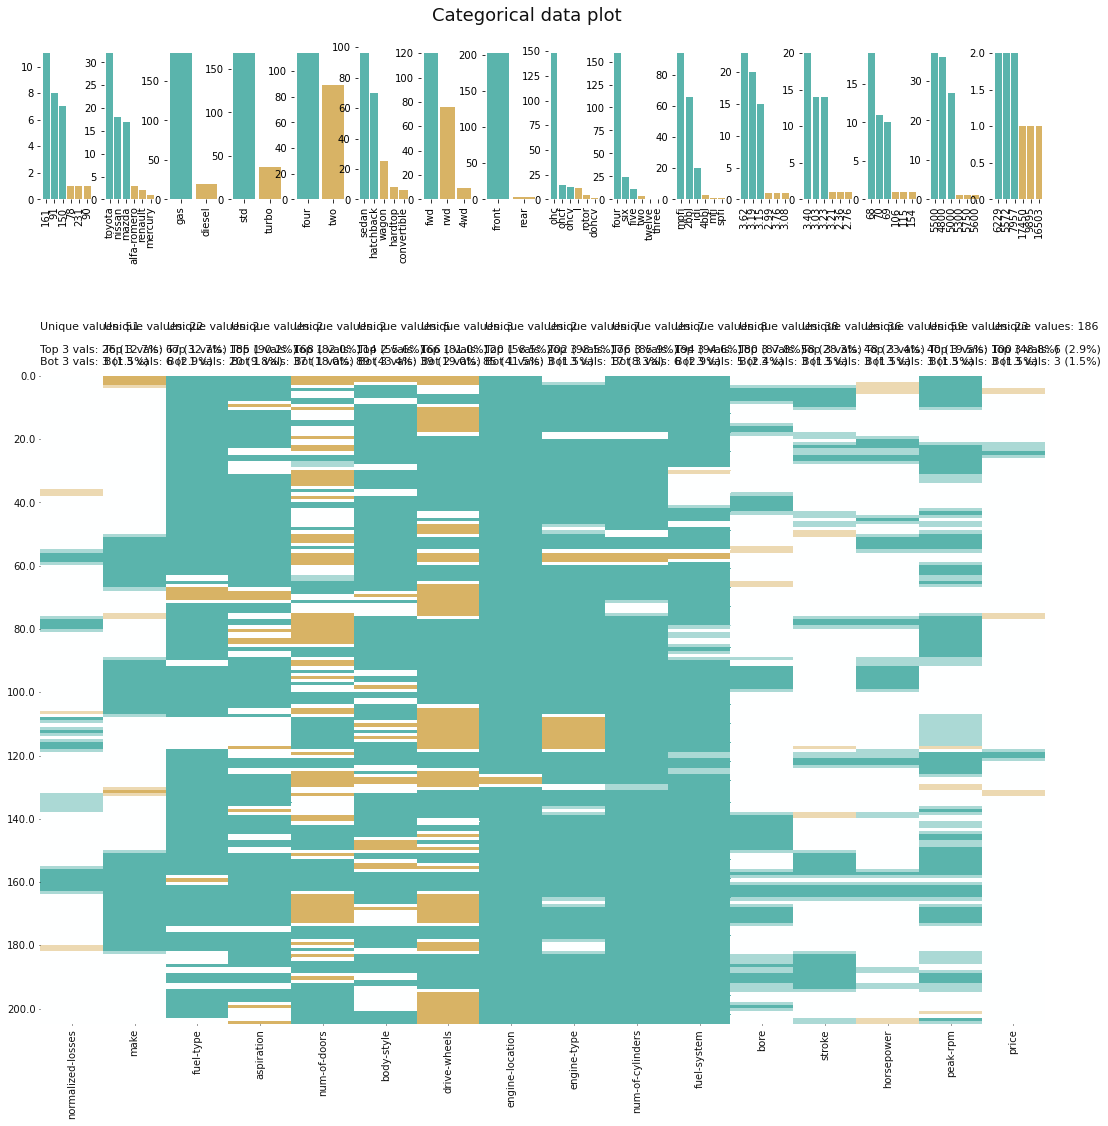

In [3]:
# number and frequency of categorical data
klib.cat_plot(cars)

In [4]:
# correlation matrix
klib.corr_mat(cars)

Displaying positive correlations. Specify a positive "threshold" to limit the results further.
Displaying negative correlations. Specify a negative "threshold" to limit the results further.


<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

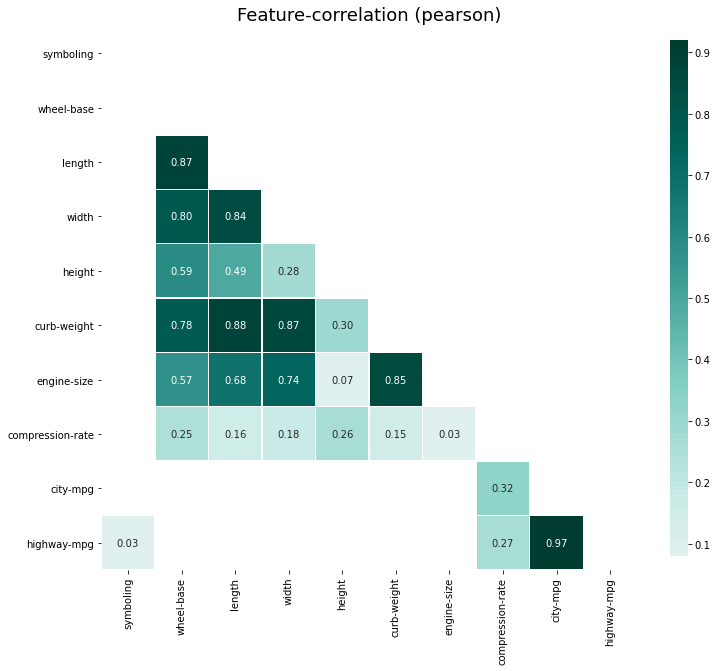

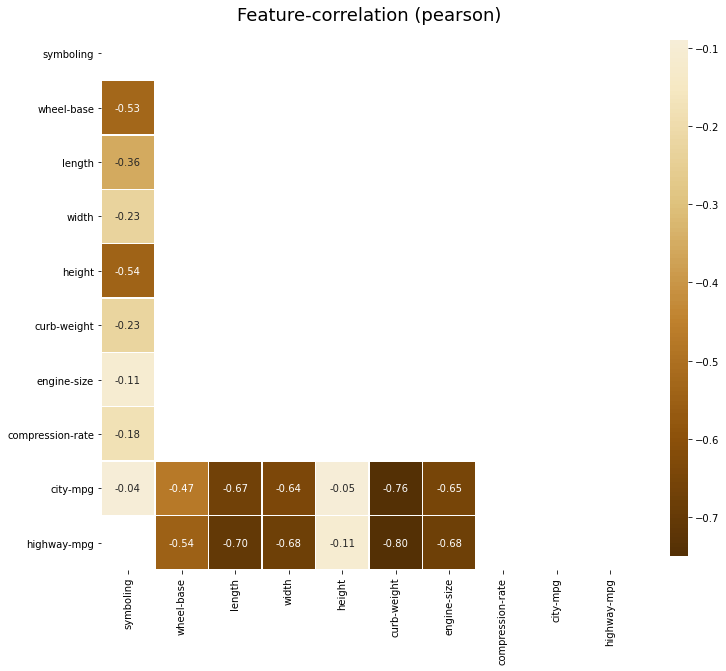

In [5]:
klib.corr_plot(cars, split='pos')
klib.corr_plot(cars, split='neg')

<AxesSubplot:xlabel='highway-mpg', ylabel='Density'>

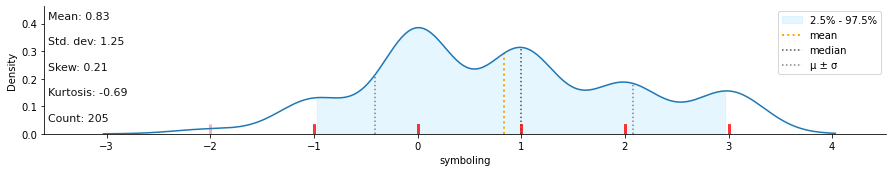

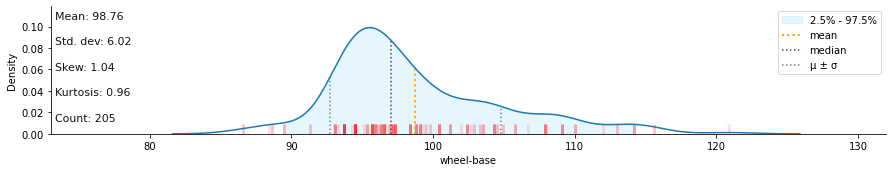

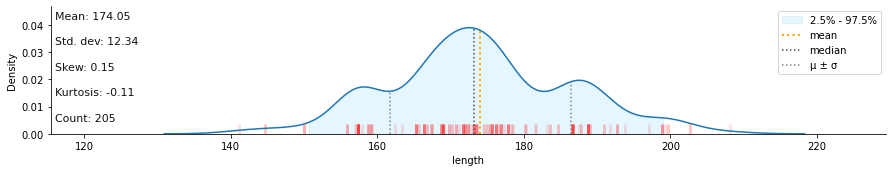

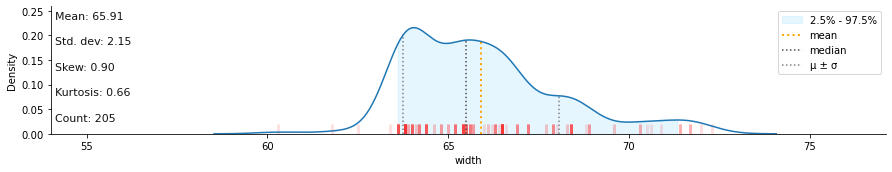

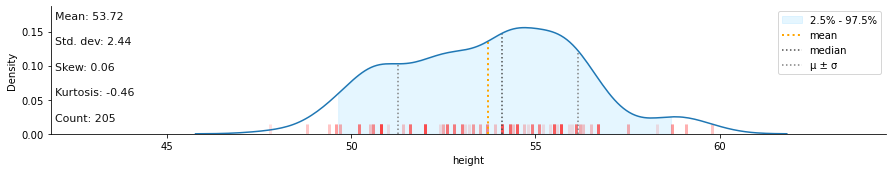

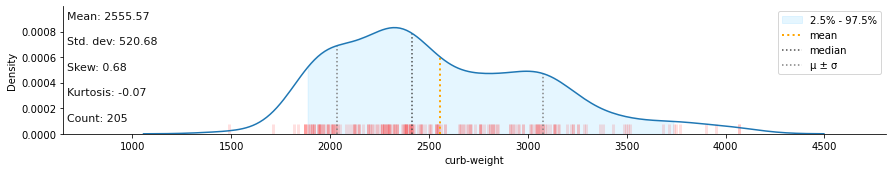

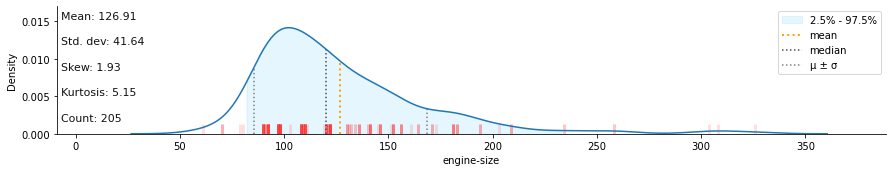

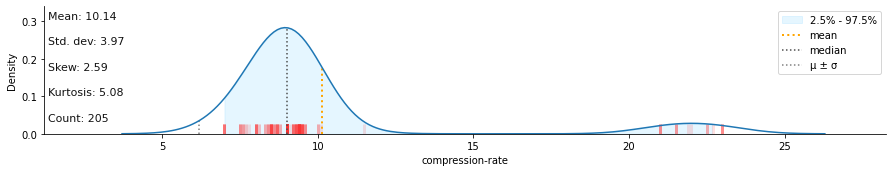

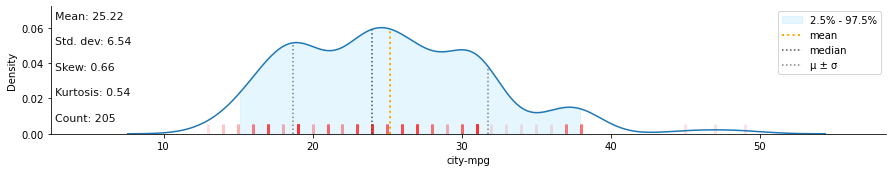

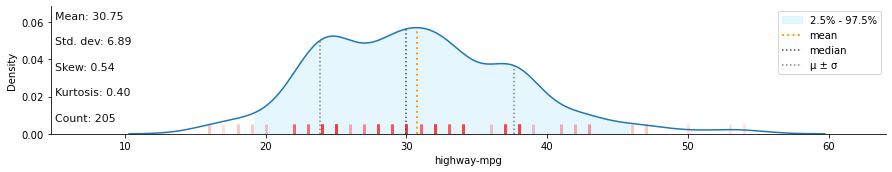

In [6]:
klib.dist_plot(cars)

GridSpec(6, 6)

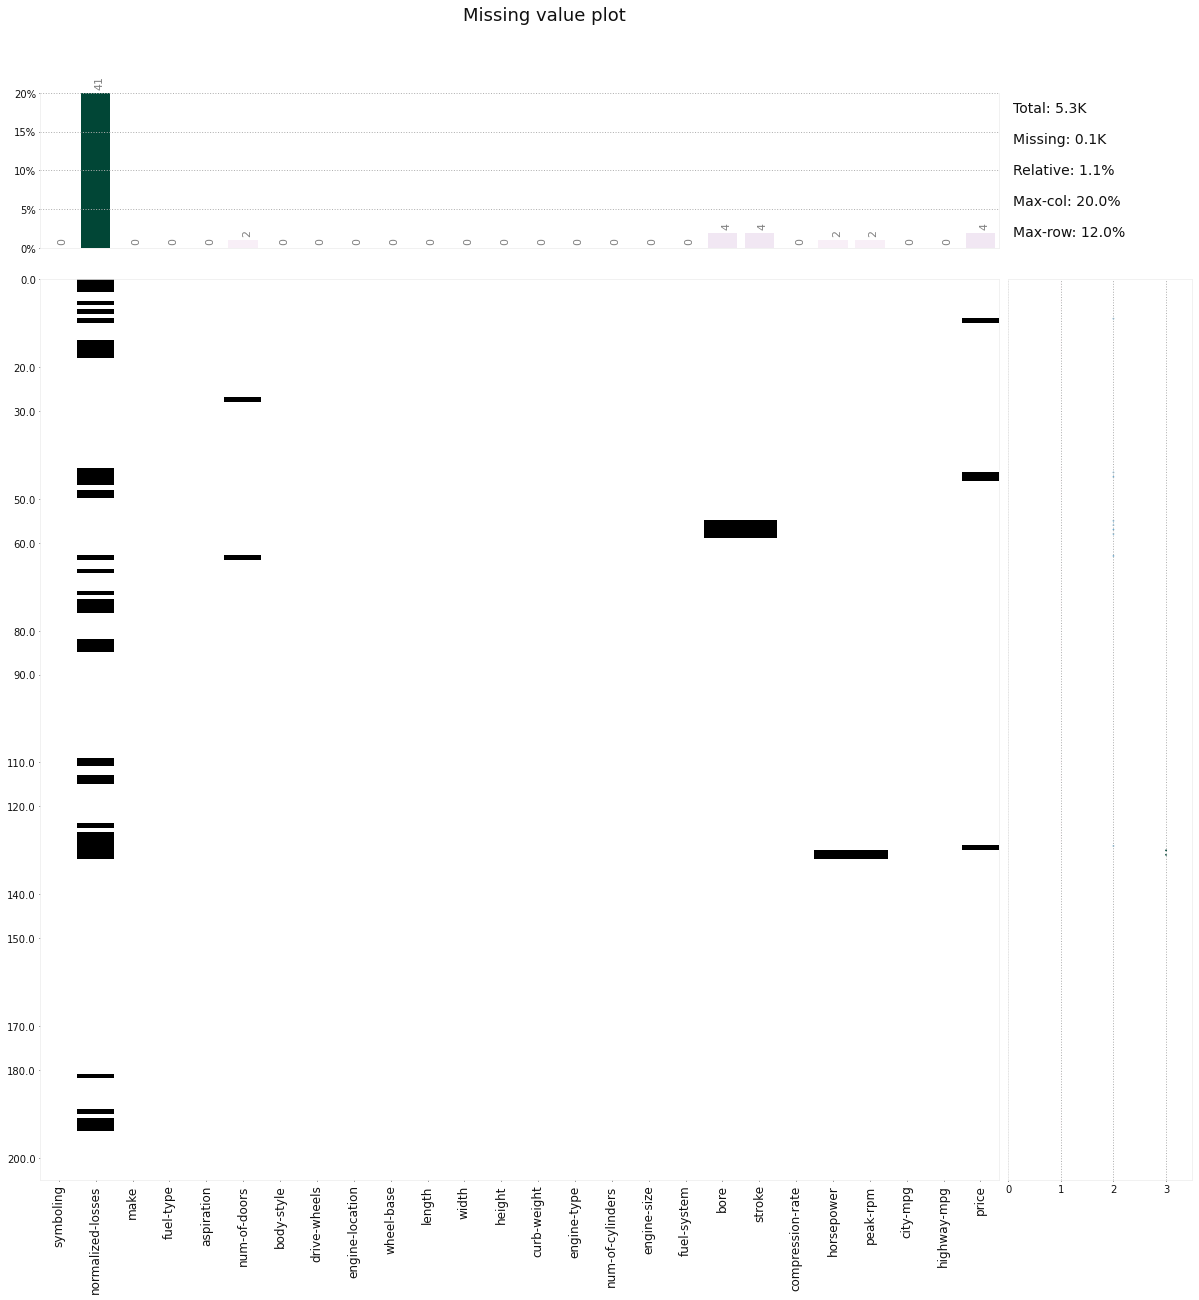

In [7]:
# missing data points
klib.missingval_plot(cars)

In [8]:
cars.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

In [3]:
# select numeric columns, change them to float, and fill NaN values with column mean
num_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

to_float = ['price','stroke','peak-rpm','horsepower','bore','normalized-losses']

missing_vals = ['normalized-losses','bore','stroke','horsepower','peak-rpm','price']

for col in to_float:
    cars[col] = cars[col].astype(float)

for col in missing_vals:
    cars[col] = cars[col].fillna(cars[col].median())

# change categorical columns
categories = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system']

# for c in categories:
#     cars[c] = cars[c].astype('category')

In [4]:
# split the dataframe into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(cars.drop(['price'], axis=1), cars['price'], test_size=0.3, random_state=0)
X_train.shape, X_test.shape, cars.shape

((143, 25), (62, 25), (205, 26))

In [5]:
#transform the target with log
y_train = np.log(y_train)
y_test = np.log(y_test)

In [6]:
# identifying categorial variables
categorical = [var for var in X_train.columns if cars[var].dtype == 'O']
len(categorical)

10

In [7]:
# cast all variables as categorical, for automatic use with Feature-engine

X_train[categorical] = X_train[categorical].astype('O')
X_test[categorical] = X_test[categorical].astype('O')

In [8]:
master_data = cars.copy()

In [9]:
# variables to impute with the most frequent category
categorical_mode = [var for var in categorical 
                    if master_data[var].isnull().sum()>0 
                    and master_data[var].isnull().mean()<0.1]

# variables to impute with the string missing
categorical_missing = [var for var in categorical 
                       if master_data[var].isnull().sum()>0 
                       and master_data[var].isnull().mean()>=0.1]

len(categorical_mode), len(categorical_missing)

(1, 0)

In [10]:
# let's find the numerical variables

numerical = [var for var in X_train.columns if var not in categorical]

len(numerical)

15

In [11]:
# variables to impute with the most frequent category
numerical_median = [var for var in numerical 
                    if master_data[var].isnull().sum()>0 
                    and master_data[var].isnull().mean()<0.1]

# variables to impute with the string missing
numerical_arbitrary = [var for var in numerical 
                       if master_data[var].isnull().sum()>0 
                       and master_data[var].isnull().mean()>=0.1]

len(numerical_median), len(numerical_arbitrary)

(0, 0)

In [12]:
# let's find non-discrete variables

discretize = [
    var for var in numerical if len(X_train[var].unique()) >= 20
]

# number of discrete variables
len(discretize)

14

# Feature engineering pipelines

In [13]:
linear_pipe = Pipeline([
    # this transformer sums the variables to combine in anew variable with the indicted name
    ('dimensions', creation.MathematicalCombination(
        variables_to_combine=['wheel-base', 'length', 'width', 'height'],
        math_operations=['sum'], 
        new_variables_names=['Dimensions'])),
    ('engine_internals', creation.MathematicalCombination(
        variables_to_combine=['bore','stroke','compression-rate'],
        math_operations=['sum'],
        new_variables_names=['Engine_Internals']
    )),
    ('consumption', creation.MathematicalCombination(
        variables_to_combine=['city-mpg','highway-mpg'],
        math_operations=['mean'],
        new_variables_names=['Comsumption']
    )),
    ('missing_ind', imp.AddMissingIndicator(
        missing_only=True, variables=numerical_arbitrary+categorical_mode
    )),
    ('arbitrary_number', imp.EndTailImputer(
        imputation_method='iqr', tail='right', fold=3, variables=numerical_arbitrary
    )),
    ('median', imp.MeanMedianImputer(
        imputation_method='median', variables=numerical_median
    )),
    ('frequent', imp.CategoricalImputer(
        imputation_method='frequent', variables=categorical_mode, return_object=True
    )),
    ('transformation', tf.YeoJohnsonTransformer(variables=discretize)),
    ('encoder', enc.OneHotEncoder(top_categories=10)),
    ('scaler', StandardScaler())
])

In [14]:
# fit the pipeline
linear_pipe.fit(X_train, y_train)

# transform the data 
X_train_linear = linear_pipe.transform(X_train)
X_test_linear = linear_pipe.transform(X_test)

In [15]:
monotonic_pipe = Pipeline([
    # this transformer sums the variables to combine in anew variable with the indicted name
    ('dimensions', creation.MathematicalCombination(
        variables_to_combine=['wheel-base', 'length', 'width', 'height'],
        math_operations=['sum'], 
        new_variables_names=['Dimensions'])),
    ('engine_internals', creation.MathematicalCombination(
        variables_to_combine=['bore','stroke','compression-rate'],
        math_operations=['sum'],
        new_variables_names=['Engine_Internals']
    )),
    ('consumption', creation.MathematicalCombination(
        variables_to_combine=['city-mpg','highway-mpg'],
        math_operations=['mean'],
        new_variables_names=['Comsumption']
    )),
    ('missing_ind', imp.AddMissingIndicator(
        missing_only=True, variables=numerical_arbitrary+categorical_mode
    )),
    ('arbitrary_number', imp.EndTailImputer(
        imputation_method='iqr', tail='right', fold=3, variables=numerical_arbitrary
    )),
    ('median', imp.MeanMedianImputer(
        imputation_method='median', variables=numerical_median
    )),
    ('frequent', imp.CategoricalImputer(
        imputation_method='frequent', variables=categorical_mode, return_object=True
    )),
    ('rare_grouping', enc.RareLabelEncoder(
        tol=0.1, n_categories=1
    )),
    ('discretizer', disc.EqualFrequencyDiscretiser(
        variables=discretize, return_object=True
    )),
    ('encoder', enc.OrdinalEncoder(encoding_method='ordered')),
    ('scaler', StandardScaler())
])

In [16]:
monotonic_pipe.fit(X_train, y_train)

X_train_monotonic = monotonic_pipe.transform(X_train)
X_test_monotonic = monotonic_pipe.transform(X_test)

In [17]:
tree_pipe = Pipeline([
    # this transformer sums the variables to combine in anew variable with the indicted name
    ('dimensions', creation.MathematicalCombination(
        variables_to_combine=['wheel-base', 'length', 'width', 'height'],
        math_operations=['sum'], 
        new_variables_names=['Dimensions'])),
    ('engine_internals', creation.MathematicalCombination(
        variables_to_combine=['bore','stroke','compression-rate'],
        math_operations=['sum'],
        new_variables_names=['Engine_Internals']
    )),
    ('consumption', creation.MathematicalCombination(
        variables_to_combine=['city-mpg','highway-mpg'],
        math_operations=['mean'],
        new_variables_names=['Comsumption']
    )),
    ('missing_ind', imp.AddMissingIndicator(
        missing_only=True, variables=numerical_arbitrary+categorical_mode
    )),
    ('arbitrary_number', imp.EndTailImputer(
        imputation_method='iqr', tail='right', fold=3, variables=numerical_arbitrary
    )),
    ('median', imp.MeanMedianImputer(
        imputation_method='median', variables=numerical_median
    )),
    ('frequent', imp.CategoricalImputer(
        imputation_method='frequent', variables=categorical_mode, return_object=True
    )),
    ('rare_grouping', enc.RareLabelEncoder(
        tol=0.1, n_categories=1
    )),
    ('discretizer', disc.DecisionTreeDiscretiser(
        cv=3, scoring='neg_mean_squared_error', variables=discretize,
        regression=True, random_state=0
    )),
    ('encoder', enc.DecisionTreeEncoder(
        encoding_method='arbitrary', cv=3, scoring='neg_mean_squared_error',
        regression=True, random_state=0
    )),
    ('scaler', StandardScaler())
])

In [18]:
tree_pipe.fit(X_train, y_train)

X_train_tree = tree_pipe.transform(X_train)
X_test_tree = tree_pipe.transform(X_test)

# Machine learning model library

In [19]:
# gradient boosting regressor

gbm_params = dict(
    loss=['ls','huber'],
    n_estimators=[10,20,50,100,200],
    min_samples_split=[0.01, 0.1, 0.3],
    max_depth=[1,2,3,None]
)

gbm = GradientBoostingRegressor(
    loss='ls',
    n_estimators=100,
    criterion='friedman_mse',
    min_samples_split=2,
    max_depth=3,
    random_state=0,
    n_iter_no_change=2,
    tol=0.0001
)

In [20]:
gbm_grid = RandomizedSearchCV(gbm, gbm_params, scoring='neg_mean_squared_error', n_iter=100, random_state=1)

gbm_linear = gbm_grid.fit(X_train_linear, y_train)
gbm_monotonic = gbm_grid.fit(X_train_monotonic, y_train)
gbm_tree = gbm_grid.fit(X_train_tree, y_train)

In [21]:
gbm_linear.best_params_

{'n_estimators': 200, 'min_samples_split': 0.3, 'max_depth': 3, 'loss': 'ls'}

In [22]:
# function to get the results of the grid search

def plot_grid(grid, title):
    
    # make df with results
    results = pd.DataFrame(grid.cv_results_)
    results.sort_values(by='mean_test_score', ascending=False, inplace=True)
    results.reset_index(drop=True, inplace=True)
    
    # plot results
    results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)
    plt.ylabel('Mean test score')
    plt.title(title)
    plt.show()
    
    return None

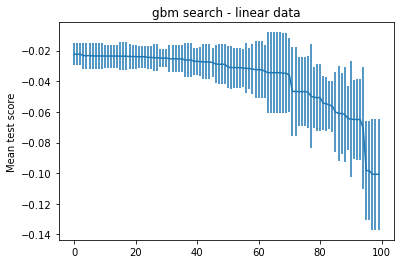

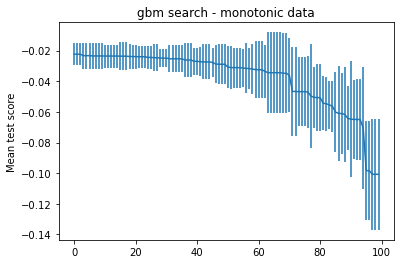

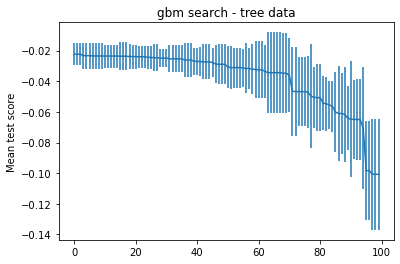

In [23]:
plot_grid(gbm_linear, 'gbm search - linear data')
plot_grid(gbm_monotonic, 'gbm search - monotonic data')
plot_grid(gbm_tree, 'gbm search - tree data')

In [24]:
# elastic net - linear model

elastic_param = dict(
    max_iter=[50000,100000],
    alpha=[0.001, 0.01],
    l1_ratio=[0,0.2,0.5,0.7,1]
)
elastic = ElasticNet(
    alpha=1.0,
    l1_ratio=0.5,
    max_iter=100000,
    random_state=0
)

In [25]:
elastic_grid = GridSearchCV(elastic, elastic_param, scoring='neg_mean_squared_error')
elastic_linear = elastic_grid.fit(X_train_linear, y_train)
elastic_monotonic = elastic_grid.fit(X_train_monotonic, y_train)
elastic_tree = elastic_grid.fit(X_train_tree, y_train)

In [26]:
elastic_linear.best_params_

{'alpha': 0.01, 'l1_ratio': 1, 'max_iter': 50000}

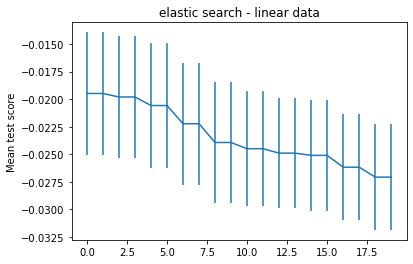

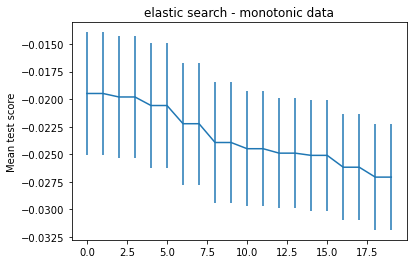

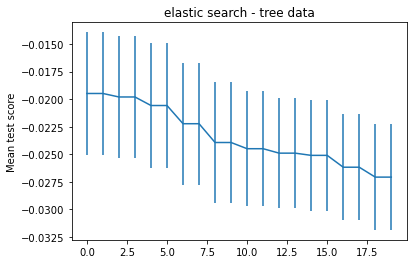

In [27]:
plot_grid(elastic_linear, 'elastic search - linear data')
plot_grid(elastic_monotonic, 'elastic search - monotonic data')
plot_grid(elastic_tree, 'elastic search - tree data')

In [28]:
# nearest neighbors

knn_params = dict(
    n_neighbors=[3,5,10],
    algorithm=['ball_tree','kd_tree','brute'],
    p=[1,2]
)

knn = KNeighborsRegressor(
    n_neighbors=5,
    algorithm='auto',
    leaf_size=30,
    p=2
)

In [29]:
knn_grid = GridSearchCV(knn, knn_params, scoring='neg_mean_squared_error')
knn_linear = knn_grid.fit(X_train_linear, y_train)
knn_monotonic = knn_grid.fit(X_train_monotonic, y_train)
knn_tree = knn_grid.fit(X_train_tree, y_train)

In [30]:
knn_linear.best_params_

{'algorithm': 'brute', 'n_neighbors': 5, 'p': 1}

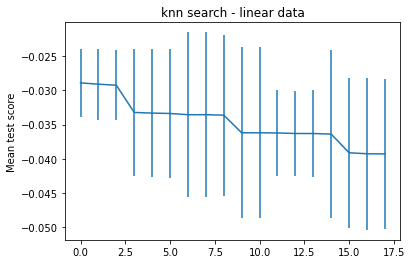

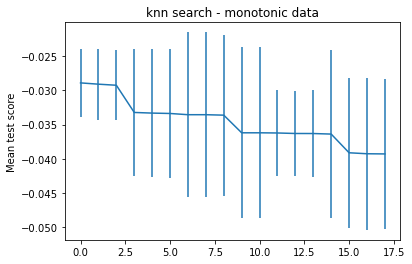

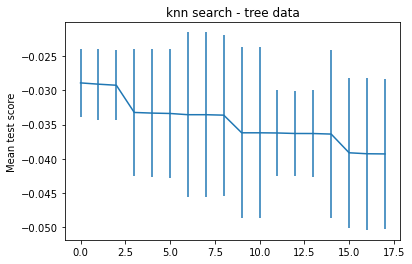

In [31]:
plot_grid(knn_linear, 'knn search - linear data')
plot_grid(knn_monotonic, 'knn search - monotonic data')
plot_grid(knn_tree, 'knn search - tree data')

In [32]:
# Light GBM

lgbm_param = {
    "num_leaves": [20,30,40],
    "max_depth": [4, 6, 10, 20],
    "n_estimators": [20, 64, 100],
}

lgbm = LGBMRegressor(
    learning_rate = 0.16060612646519587, 
    min_child_weight = 0.4453842422224686,
    objective='regression', 
    random_state=0)

In [33]:
lgbm_grid = GridSearchCV(lgbm, lgbm_param, scoring='neg_mean_squared_error')

lgbm_linear = lgbm_grid.fit(X_train_linear, y_train)
lgbm_monotonic = lgbm_grid.fit(X_train_monotonic, y_train)
lgbm_tree = lgbm_grid.fit(X_train_tree, y_train)

LightGBMError: Check failed: (best_split_info.right_count) > (0) at /Users/runner/work/1/s/python-package/compile/src/treelearner/serial_tree_learner.cpp, line 661 .


In [ ]:
# lgbm_linear.best_params_

In [ ]:
# plot_grid(lgbm_linear, 'lgbm search - linear data')
# plot_grid(lgbm_monotonic, 'lgbm search - monotonic data')
# plot_grid(lgbm_tree, 'lgbm search - tree data')

In [46]:
# Support vector regressor
svr_params = {
    'kernel': ['poly','rbf'],
    'C': [0.053677105521141605, 0.1],
    "epsilon": [0.03925943476562099, 0.1],
    "coef0": [0.9486751042886584, 0.5],
}

svr = SVR(
    kernel='rbf',
    degree=3,
    C=1.0,
    )

In [47]:
svr_grid = GridSearchCV(svr, svr_params, scoring='neg_mean_squared_error')

svr_linear = svr_grid.fit(X_train_linear, y_train)
svr_monotonic = svr_grid.fit(X_train_monotonic, y_train)
svr_tree = svr_grid.fit(X_train_tree, y_train)

In [48]:
svr_linear.best_params_

{'C': 0.053677105521141605,
 'coef0': 0.9486751042886584,
 'epsilon': 0.03925943476562099,
 'kernel': 'poly'}

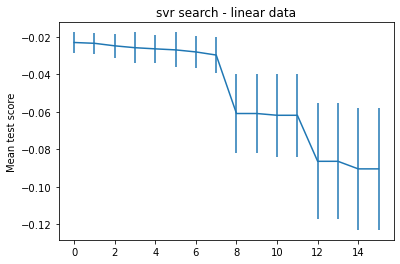

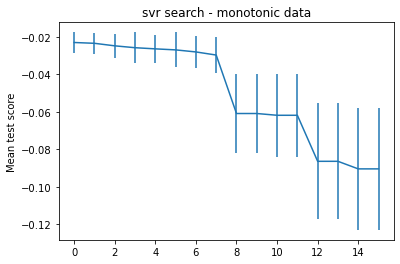

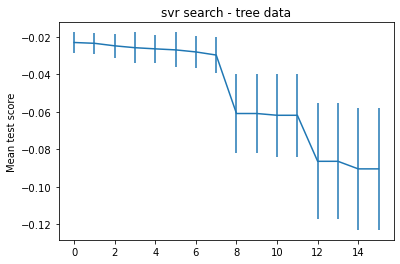

In [49]:
plot_grid(svr_linear, 'svr search - linear data')
plot_grid(svr_monotonic, 'svr search - monotonic data')
plot_grid(svr_tree, 'svr search - tree data')

In [50]:
# gradient boosting regressor

rf_param = dict(
    n_estimators=[100, 200, 500, 1000],
    min_samples_split=[0.1, 0.3, 0.5, 1.0],
    max_depth=[1,2,3,None],
    )

rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,
    max_depth=3,
    random_state=0,
    n_jobs=-1,
    )

In [51]:
rf_grid = RandomizedSearchCV(rf, rf_param, scoring='neg_mean_squared_error', n_iter=10, random_state=0)

# rf_grid = GridSearchCV(rf, rf_param, scoring='neg_mean_squared_error')

rf_linear = rf_grid.fit(X_train_linear, y_train)
rf_monotonic = rf_grid.fit(X_train_monotonic, y_train)
rf_tree = rf_grid.fit(X_train_tree, y_train)

In [52]:
rf_linear.best_params_

{'n_estimators': 500, 'min_samples_split': 0.1, 'max_depth': 3}

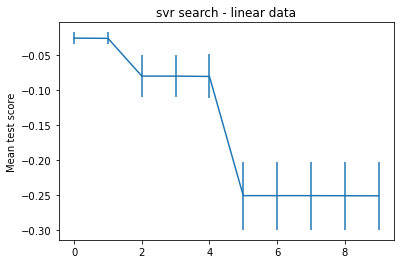

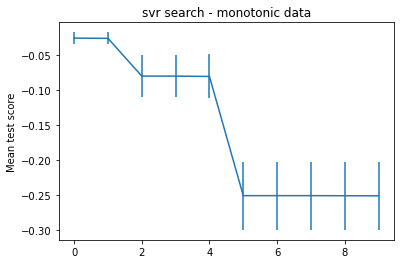

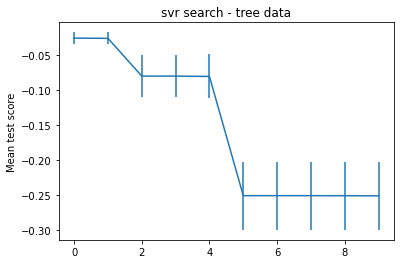

In [53]:
plot_grid(rf_linear, 'svr search - linear data')
plot_grid(rf_monotonic, 'svr search - monotonic data')
plot_grid(rf_tree, 'svr search - tree data')

In [54]:
def select_best_score(grid):
    results = pd.DataFrame(grid.cv_results_)
    results.sort_values(by='mean_test_score', ascending=False, inplace=True)
    results = results[['mean_test_score','std_test_score']]
    return results.head(1)

select_best_score(rf_linear)

mean_test_score  std_test_score
4        -0.025669        0.008361

In [57]:
results = pd.concat([
    select_best_score(gbm_linear),
    select_best_score(gbm_monotonic),
    select_best_score(gbm_tree),
    
    select_best_score(elastic_linear),
    select_best_score(elastic_monotonic),
    select_best_score(elastic_tree),
    
    select_best_score(knn_linear),
    select_best_score(knn_monotonic),
    select_best_score(knn_tree),
    
    select_best_score(svr_linear),
    select_best_score(svr_monotonic),
    select_best_score(svr_tree),
    
    # select_best_score(lgbm_linear),
    # select_best_score(lgbm_monotonic),
    # select_best_score(lgbm_tree),
    
    select_best_score(rf_linear),
    select_best_score(rf_monotonic),
    select_best_score(rf_tree),
    ], axis=0)

results.index = [
    'gbm_linear','gbm_monotonic', 'gbm_tree',
    'elastic_linear','elastic_monotonic', 'elastic_tree',
    'knn_linear','knn_monotonic', 'knn_tree',
    'svr_linear','svr_monotonic', 'svr_tree',
    # 'lgbm_linear','lgbm_monotonic', 'lgbm_tree',
    'rf_linear','rf_monotonic', 'rf_tree',
]

results.sort_values(by='mean_test_score', ascending=False, inplace=True)

results.head()

mean_test_score  std_test_score
elastic_linear           -0.019486        0.005558
elastic_monotonic        -0.019486        0.005558
elastic_tree             -0.019486        0.005558
gbm_linear               -0.022319        0.007346
gbm_monotonic            -0.022319        0.007346

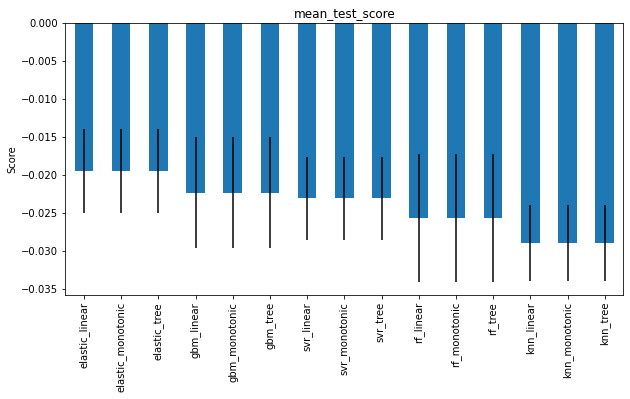

In [58]:
results['mean_test_score'].plot.bar(
    yerr=[results['std_test_score'], results['std_test_score']],
    subplots=True, figsize=(10,5)
)
plt.ylabel('Score')
plt.show()

## Comparing performnce

In [62]:
X_train_preds = elastic_monotonic.predict(X_train_monotonic)
X_test_preds = elastic_monotonic.predict(X_test_monotonic)

print('Train mse: ', mean_squared_error(y_train, X_train_preds, squared=False))
print('Test rmse: ', mean_squared_error(y_test, X_test_preds, squared=False))
print()
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

Train mse:  0.20706135566689998
Test rmse:  0.24131247372639847

Train r2:  0.8279995114547549
Test r2:  0.7566909688551411


In [63]:
# svr predictions
X_train_preds = svr_monotonic.predict(X_train_monotonic)
X_test_preds = svr_monotonic.predict(X_test_monotonic)

print('Train rmse: ', mean_squared_error(y_train, X_train_preds,squared=False))
print('Test rmse: ', mean_squared_error(y_test, X_test_preds,squared=False))
print()
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

Train rmse:  0.1734730468388018
Test rmse:  0.22507647308602519

Train r2:  0.8792754522671234
Test r2:  0.7883302053758485


In [64]:
# gradient boosting regressor predictions
X_train_preds = gbm_tree.predict(X_train_tree)
X_test_preds = gbm_tree.predict(X_test_tree)

print('Train rmse: ', mean_squared_error(y_train, X_train_preds,squared=False))
print('Test rmse: ', mean_squared_error(y_test, X_test_preds,squared=False))
print()
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

Train rmse:  0.09327989579024215
Test rmse:  0.25504274398522875

Train r2:  0.9650933896012001
Test r2:  0.7282155341125965


In [65]:
## Model stacking

In [67]:
estimators = [
    ('gbm_linear',gbm_linear.best_estimator_),
    ('gbm_monotonic',gbm_monotonic.best_estimator_),
    ('gbm_tree',gbm_tree.best_estimator_),
    ('elastic_linear',elastic_linear.best_estimator_),
    ('elastic_monotonic',elastic_monotonic.best_estimator_),
    ('elastic_tree',elastic_tree.best_estimator_),
    ('knn_linear',knn_linear.best_estimator_),
    ('knn_monotonic',knn_monotonic.best_estimator_),
    ('knn_tree',knn_tree.best_estimator_),
    ('svr_linear',svr_linear.best_estimator_),
    ('svr_monotonic',svr_monotonic.best_estimator_),
    ('svr_tree',svr_tree.best_estimator_),
    # ('lgbm_linear',lgbm_linear.best_estimator_),
    # ('lgbm_monotonic',lgbm_monotonic.best_estimator_),
    # ('lgbm_tree',lgbm_tree.best_estimator_),
    ('rf_linear',rf_linear.best_estimator_),
    ('rf_monotonic',rf_monotonic.best_estimator_),
    ('rf_tree', rf_tree.best_estimator_),
]

stacked = StackingRegressor(
    estimators=estimators,
    final_estimator=LGBMRegressor(random_state=1)
)

In [69]:
stacking = cross_validate(
    stacked, X_train_linear, y_train, cv=5, scoring='neg_mean_squared_error', return_estimator=True
)
stacking['test_score'].mean(), stacking['test_score'].std()

(-0.03940349379420855, 0.009552203104696122)

In [70]:
stacking = cross_validate(
    stacked, X_train_monotonic, y_train, cv=5,
    scoring='neg_mean_squared_error', return_estimator=True)

stacking['test_score'].mean(), stacking['test_score'].std()

(-0.03661343466600878, 0.01358763540953702)

In [71]:
stacking = cross_validate(
    stacked, X_train_tree, y_train, cv=5,
    scoring='neg_mean_squared_error', return_estimator=True)

stacking['test_score'].mean(), stacking['test_score'].std()

(-0.028590019715679343, 0.009217036361449589)

In [72]:
stacked.fit(X_train_tree, y_train)

StackingRegressor(estimators=[('gbm_linear',
                               GradientBoostingRegressor(min_samples_split=0.3,
                                                         n_estimators=200,
                                                         n_iter_no_change=2,
                                                         random_state=0)),
                              ('gbm_monotonic',
                               GradientBoostingRegressor(min_samples_split=0.3,
                                                         n_estimators=200,
                                                         n_iter_no_change=2,
                                                         random_state=0)),
                              ('gbm_tree',
                               GradientBoostingRegressor(min_samples_split=0.3,
                                                         n_estimators=200,
                                                         n_iter_no_...
                        

In [76]:
# stacked model predictions
X_train_preds = stacked.predict(X_train_tree)
X_test_preds = stacked.predict(X_test_tree)

print('Train rmse: ', mean_squared_error(y_train, X_train_preds,squared=False))
print('Test rmse: ', mean_squared_error(y_test, X_test_preds,squared=False))
print()
print('Train r2: ', r2_score(y_train, X_train_preds))
print('Test r2: ', r2_score(y_test, X_test_preds))

Train rmse:  0.14700766586636052
Test rmse:  0.23150661749955453

Train r2:  0.9133015090286891
Test r2:  0.7760631807736482


In [ ]:
X_train_linear.head()

In [ ]:
X_train_linear['body-style'] = X_train_linear['body-style'].astype('category').cat.codes

In [ ]:
categories = ['make','fuel-type','num-of-doors','body-style','drive-wheels','engine-location']

for cat in categories:
    X_train_linear[cat] = X_train_linear[cat].astype('category').cat.codes.astype('float')

In [ ]:
X_train_linear.head()

In [ ]:
min_max = preprocessing.MinMaxScaler()
car_scaled = min_max.fit_transform(numeric_cars)
df = pd.DataFrame(car_scaled, columns=continuous_values_cols)

In [ ]:
df.head()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    last_train_row = int(len(rand_df)/2)
    train_df = rand_df.iloc[:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    knn.fit(train_df[[train_col]], train_df[train_col])
    predicted_labels = knn.predict(test_df[[target_col]])
    
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

In [ ]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    last_train_row = int(len(rand_df)/2)
    train_df = rand_df.iloc[:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k, algorithm='brute')
        knn.fit(train_df[[train_col]], train_df[target_col])
        predicted_labels = knn.predict(test_df[[target_col]])
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        k_rmses[k] = rmse
    
    return k_rmses

k_rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

for cols in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for k, v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')

In [ ]:
feature_avg_rmse = {}

for k, v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse

series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_seris_avg_rmse.index

In [ ]:

def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,7):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

In [ ]:

def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

In [ ]:
for k, v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.plot(x, y, label='{}'.format(k))

plt.xlabel('k value')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
import warnings
warnings.filterwarnings('ignore')